# 2. Detecting facial expressions from images

*Written by Jin Hyun Cheong and Eshin Jolly*

In this tutorial we'll explore the `Detector` class in more depth, demonstrating how to detect faces, facial landmarks, action units, and emotions from images. You can try it out interactively in Google Collab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cosanlab/py-feat/blob/master/notebooks/content/02_detector_imgs.ipynb)

In [ ]:
# Uncomment the line below and run this only if you're using Google Collab
# !pip install -q py-feat

## 2.1 Detecting a single face from a single image

### Setting up the Detector

When using the `Detector` you can either specify specific models to use or just load the default models which are defined explicitly below:

In [ ]:
from feat import Detector

detector = Detector(
    face_model="retinaface",
    landmark_model="mobilenet",
    au_model="rf",
    emotion_model="rf",
    facepose_model="pnp"
)

detector

Let's process a single image with a single face. Py-feat includes a demo image for this purpose called `single_face.jpg` so lets use that. You can also use the convenient `imshow` function which will automatically load an image into a numpy array if provided a path unlike matplotlib:

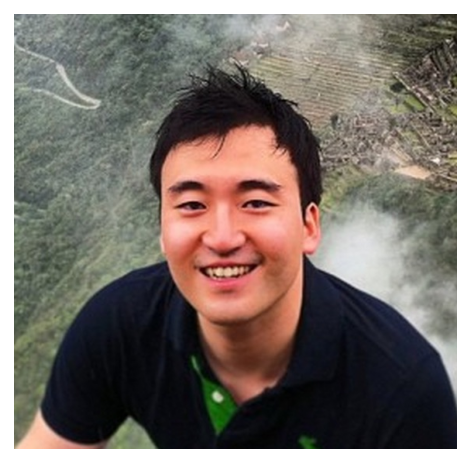

In [2]:
from feat.utils import get_test_data_path
from feat.plotting import imshow
import os

# Helper to point to the test data folder
test_data_dir = get_test_data_path()

# Get the full path
single_face_img_path = os.path.join(test_data_dir, "single_face.jpg")

# Plot it
imshow(single_face_img_path)

Now we use our initialized `detector` instance to make predictions with the `detect_image()` method. This is the main workhorse method that will perform face, landmark, au, and emotion detection using the loaded models. It always returns a `Fex` data instance:

In [22]:
single_face_prediction = detector.detect_image(single_face_img_path)

# Show results
single_face_prediction

,frame,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,FaceScore,x_0,x_1,x_2,x_3,...,Roll,Yaw,anger,disgust,fear,happiness,sadness,surprise,neutral,input
0,0,196.976837,140.997742,173.810486,257.639343,0.999681,192.864593,191.586715,192.874618,197.394792,...,-1.903955,4.869262,0.000369,0.000026,0.000485,0.986996,0.000046,0.01201,0.000068,/Users/Esh/Documents/pypackages/py-feat/feat/t...


### Working with Fex data class results

Because the output is a `Fex` data class instance, we can utilize its various helper methods and attributes to inspect our predictions.

#### Easily accessing FEX columns of interest.  

Fex data classes make it simple to access various columns of interest (AUs, emotion, faceboxes, etc): 

In [4]:
single_face_prediction.facebox

,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,FaceScore
0,196.976837,140.997742,173.810486,257.639343,0.999681


In [5]:
single_face_prediction.aus

,AU01,AU02,AU04,AU06,AU07,AU10,AU12,AU14,AU15,AU17,AU23,AU24
0,0.546606,0.96656,0.001263,0.942192,0.757494,0.074272,0.997331,0.113582,0.031618,0.000369,0.001004,0.000002


In [6]:
single_face_prediction.emotions

,anger,disgust,fear,happiness,sadness,surprise,neutral
0,0.000369,0.000026,0.000485,0.986996,0.000046,0.01201,0.000068


In [7]:
single_face_prediction.facepose # (in degrees)

,Pitch,Roll,Yaw
0,0.968232,-1.903955,4.869262


#### Saving detection to a file

We can also save our detection directly to a file by specifying an `outputFname` when using `.detect_image`. The detector will return `True` when it's finished. 

In [8]:
detector.detect_image(single_face_img_path, outputFname = "output.csv")

,frame,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,FaceScore,x_0,x_1,x_2,x_3,...,Roll,Yaw,anger,disgust,fear,happiness,sadness,surprise,neutral,input
0,0,196.976837,140.997742,173.810486,257.639343,0.999681,192.864593,191.586715,192.874618,197.394792,...,-1.903955,4.869262,0.000369,0.000026,0.000485,0.986996,0.000046,0.01201,0.000068,/Users/Esh/Documents/pypackages/py-feat/feat/t...


#### Loading detection results from a saved file

We can load this output using the `read_feat()` function, which behaves just like `pd.read_csv` from Pandas, but returns a `Fex` data class instead of a DataFrame. This gives you the full suite of Fex funcionality right away.

In [9]:
# prefer to pandas read_csv
from feat.utils import read_feat

input_prediction = read_feat("output.csv")

# Show results
input_prediction

,frame,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,FaceScore,x_0,x_1,x_2,x_3,...,Roll,Yaw,anger,disgust,fear,happiness,sadness,surprise,neutral,input
0,0,196.97684,140.99774,173.81049,257.63934,0.999681,192.864593,191.586715,192.874618,197.394792,...,-1.903955,4.869262,0.000369,0.000026,0.000485,0.986996,0.000046,0.01201,0.000068,output.csv


#### Visualizing detection results.

We can use the `.plot_detections()` method to generate a summary figure of detected faces, action units and emotions. It always returns a list of matplotlib figures:

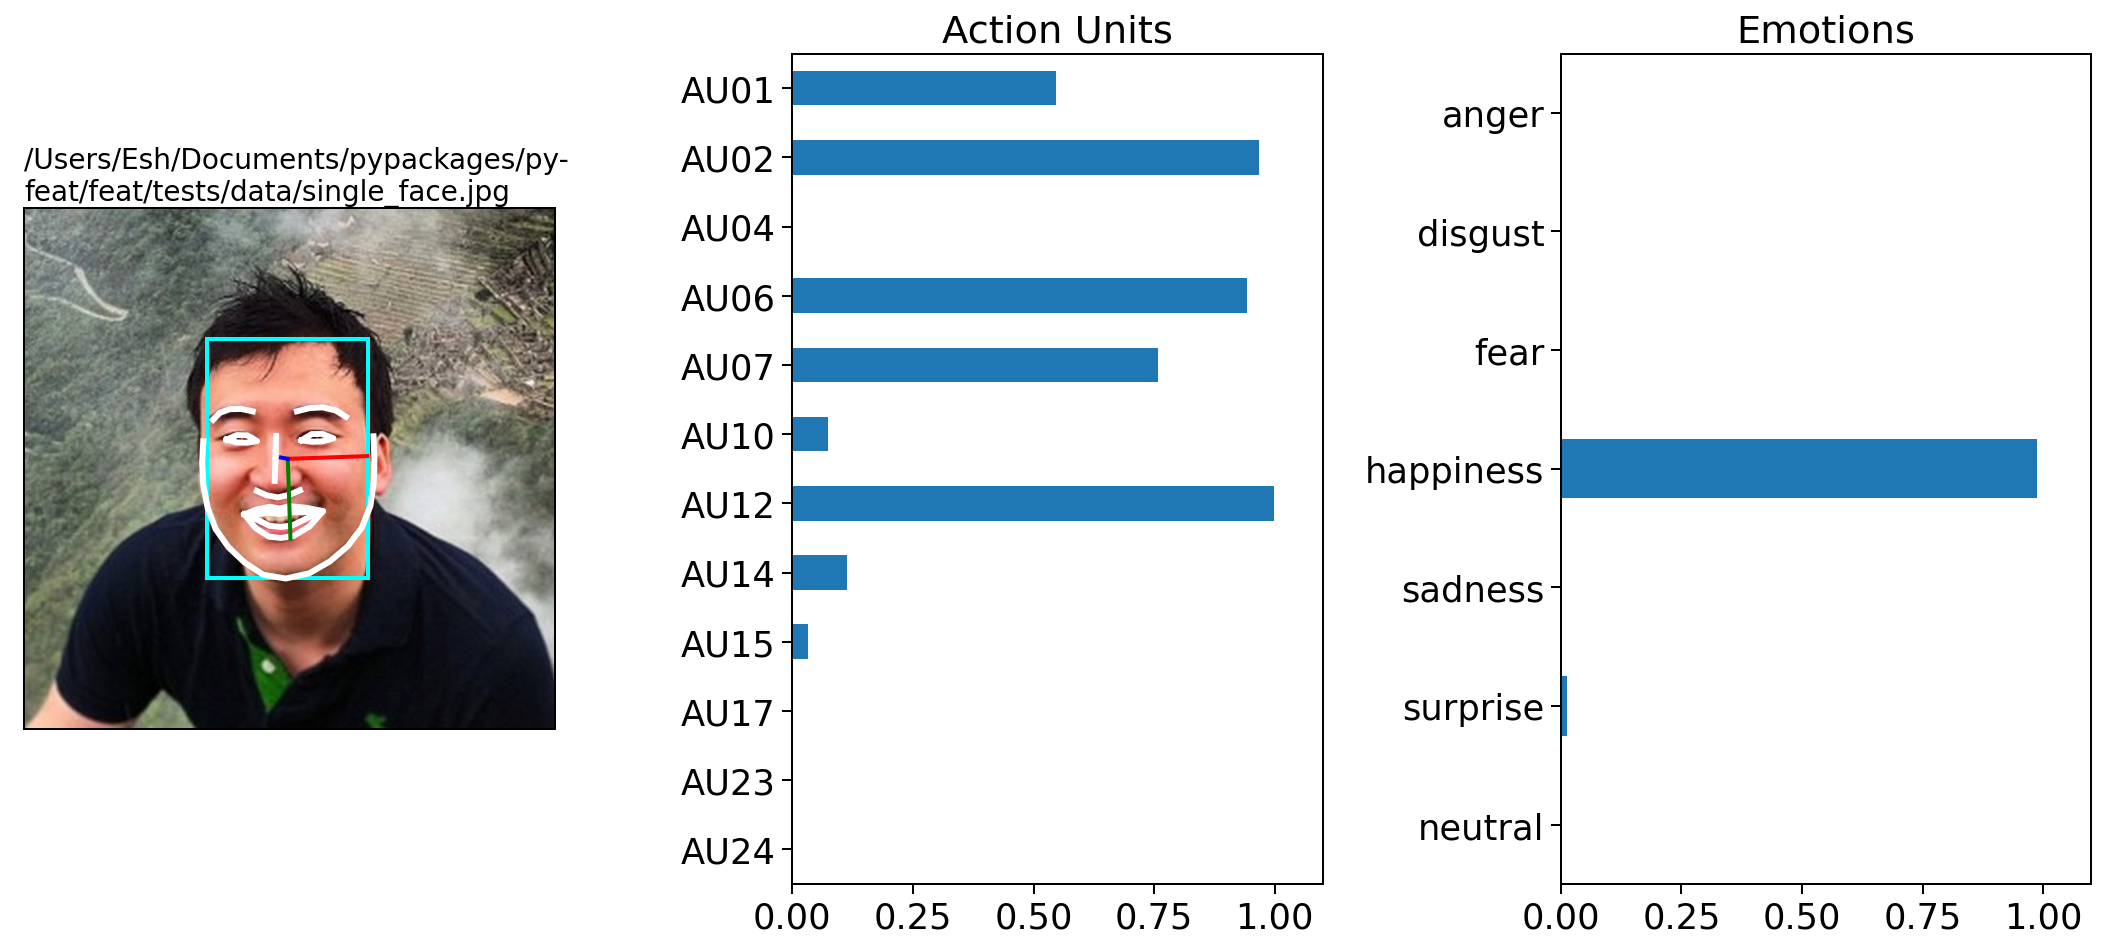

In [10]:
figs = single_face_prediction.plot_detections(poses=True)

By default `.plot_detections()` will overlay facial lines on top of the input image. However, it's also possible to visualize a face using Py-Feat's standardized AU landmark model, which takes the detected AUs and projects them onto a template face. You an control this by change by setting `faces='aus'` instead of the default `faces='landmarks'`. `For more details about this kind of visualization see [tutorial 4](./04_plotting.ipynb):

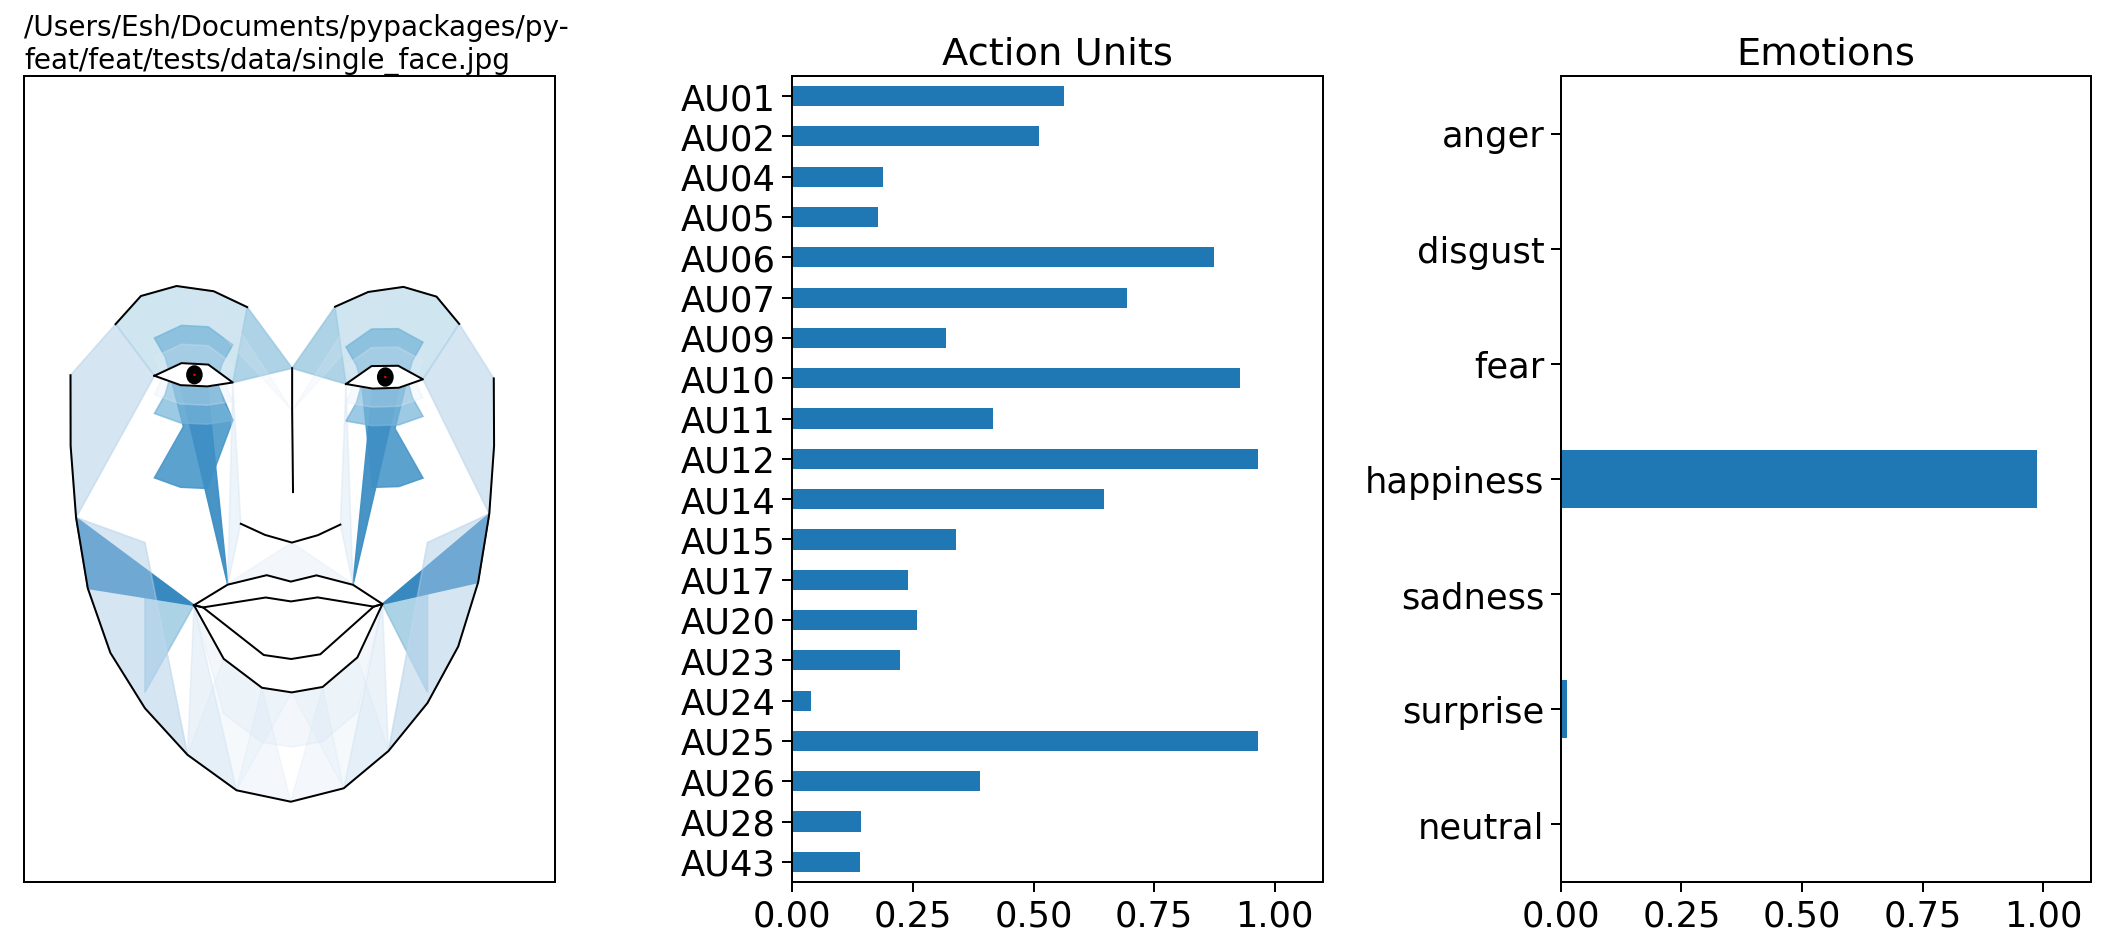

In [23]:
figs = single_face_prediction.plot_detections(faces='aus', muscles=True)

## 2.2 Detecting multiple faces from a single image 

A `Detector` can automatically find multiple faces in a single image. We'll see that in the next example, the number of rows of the Fex data class returned from `.detect_image()` has one row for each detected face. We'll also try using a different model this time, Img2Pose, which acts as both a face detector and a face pose estimator.

Notice how `image_prediction` is now a Fex instance with 5 rows, one for each detected face. We can confirm this by plotting our detection results and poses like before:

In [23]:
multi_face_image_path = os.path.join(test_data_dir, "multi_face.jpg")
multi_face_prediction = detector.detect_image(multi_face_image_path)

# Show results
multi_face_prediction

,frame,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,FaceScore,x_0,x_1,x_2,x_3,...,Roll,Yaw,anger,disgust,fear,happiness,sadness,surprise,neutral,input
0,0,683.844116,288.876495,103.788025,134.104675,0.999768,686.784072,684.581417,683.259728,683.543441,...,8.618552,10.884868,0.050378,0.002782,0.160675,0.011653,0.587488,0.075299,0.111725,/Users/Esh/Documents/pypackages/py-feat/feat/t...
1,0,533.678894,309.400024,96.237732,124.128448,0.999421,536.352308,533.773775,532.264482,532.354004,...,8.18921,7.956858,0.03112,0.001458,0.186241,0.104354,0.269578,0.014566,0.392683,/Users/Esh/Documents/pypackages/py-feat/feat/t...
2,0,316.984406,233.779205,92.016876,126.462952,0.999196,314.601803,315.56932,317.556661,320.979813,...,-2.193695,-9.569049,0.033716,0.114599,0.055362,0.181432,0.060542,0.110806,0.443542,/Users/Esh/Documents/pypackages/py-feat/feat/t...
3,0,221.29747,64.152306,85.109207,109.057442,0.996842,221.084805,218.956039,217.532472,217.588807,...,12.539567,-11.006074,0.000943,0.001107,0.036498,0.08564,0.020177,0.772348,0.083288,/Users/Esh/Documents/pypackages/py-feat/feat/t...
4,0,437.129089,213.861359,79.529785,97.050537,0.996773,439.01578,438.598761,439.10614,440.473299,...,1.993561,-1.891783,0.20795,0.002251,0.002176,0.416435,0.002668,0.219107,0.149411,/Users/Esh/Documents/pypackages/py-feat/feat/t...


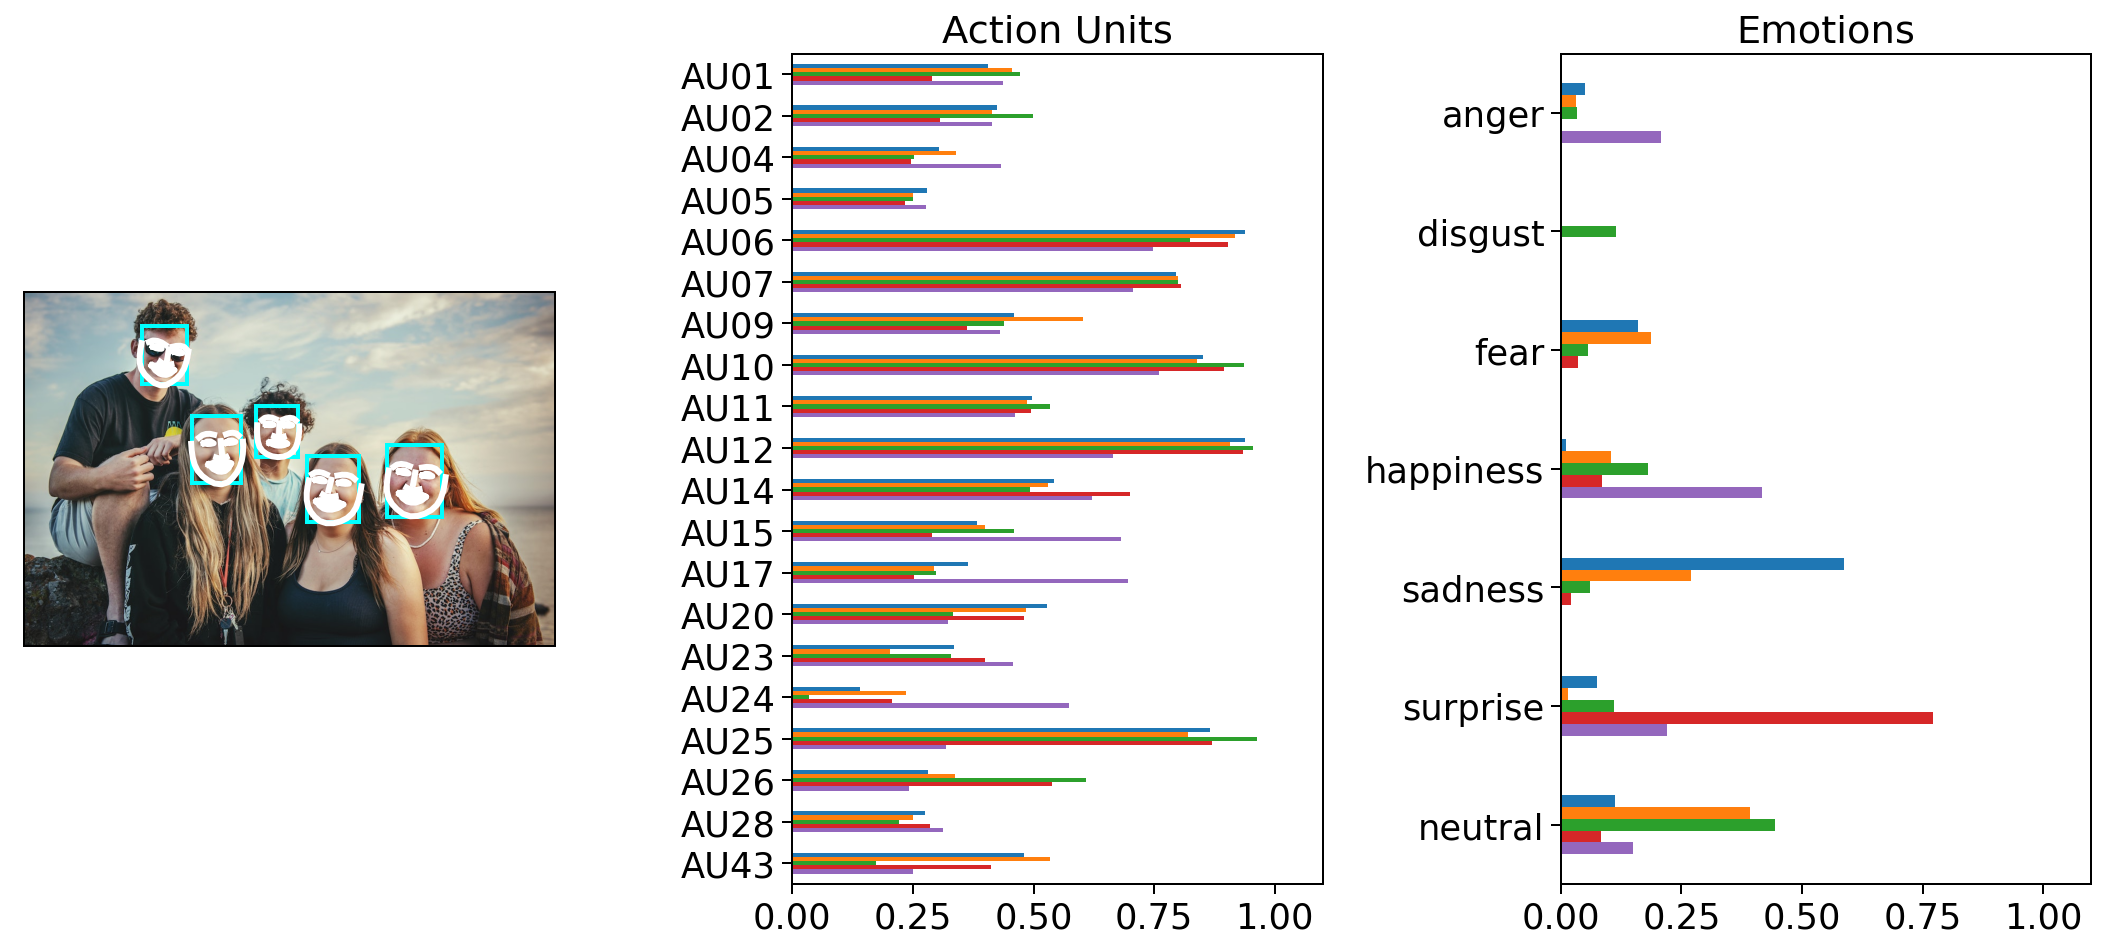

In [13]:
figs = multi_face_prediction.plot_detections(add_titles=False)

## 2.3 Detecting faces from multiple images

`Detector` is also flexible enough to process multiple image files simultaneously if `.detect_image()` is passed a list of images. You can process multiple images in a *batch* to speed up processing, but **all images in a batch must have the same dimensions**.

In the example below we process both our single and multi-face example images from above, but force Py-Feat **not** to batch process them by setting `batch_size = 1`.

Notice how the returned Fex data class instance has 6 rows: 1 for the first face in the first image, and 5 for the faces in the second image:

In [24]:
img_list = [single_face_img_path, multi_face_image_path]

mixed_prediction = detector.detect_image(img_list, batch_size=1)
mixed_prediction

,frame,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,FaceScore,x_0,x_1,x_2,x_3,...,Roll,Yaw,anger,disgust,fear,happiness,sadness,surprise,neutral,input
0,0,196.976837,140.997742,173.810486,257.639343,0.999681,192.864593,191.586715,192.874618,197.394792,...,-1.903955,4.869262,0.000369,0.000026,0.000485,0.986996,0.000046,0.01201,0.000068,/Users/Esh/Documents/pypackages/py-feat/feat/t...
1,1,683.844116,288.876495,103.788025,134.104675,0.999768,686.784072,684.581417,683.259728,683.543441,...,8.618552,10.884868,0.050378,0.002782,0.160675,0.011653,0.587488,0.075299,0.111725,/Users/Esh/Documents/pypackages/py-feat/feat/t...
2,1,533.678894,309.400024,96.237732,124.128448,0.999421,536.352308,533.773775,532.264482,532.354004,...,8.18921,7.956858,0.03112,0.001458,0.186241,0.104354,0.269578,0.014566,0.392683,/Users/Esh/Documents/pypackages/py-feat/feat/t...
3,1,316.984406,233.779205,92.016876,126.462952,0.999196,314.601803,315.56932,317.556661,320.979813,...,-2.193695,-9.569049,0.033716,0.114599,0.055362,0.181432,0.060542,0.110806,0.443542,/Users/Esh/Documents/pypackages/py-feat/feat/t...
4,1,221.29747,64.152306,85.109207,109.057442,0.996842,221.084805,218.956039,217.532472,217.588807,...,12.539567,-11.006074,0.000943,0.001107,0.036498,0.08564,0.020177,0.772348,0.083288,/Users/Esh/Documents/pypackages/py-feat/feat/t...
5,1,437.129089,213.861359,79.529785,97.050537,0.996773,439.01578,438.598761,439.10614,440.473299,...,1.993561,-1.891783,0.20795,0.002251,0.002176,0.416435,0.002668,0.219107,0.149411,/Users/Esh/Documents/pypackages/py-feat/feat/t...


Calling `.plot_detections()` will now plot detections for all images the detector was passed:

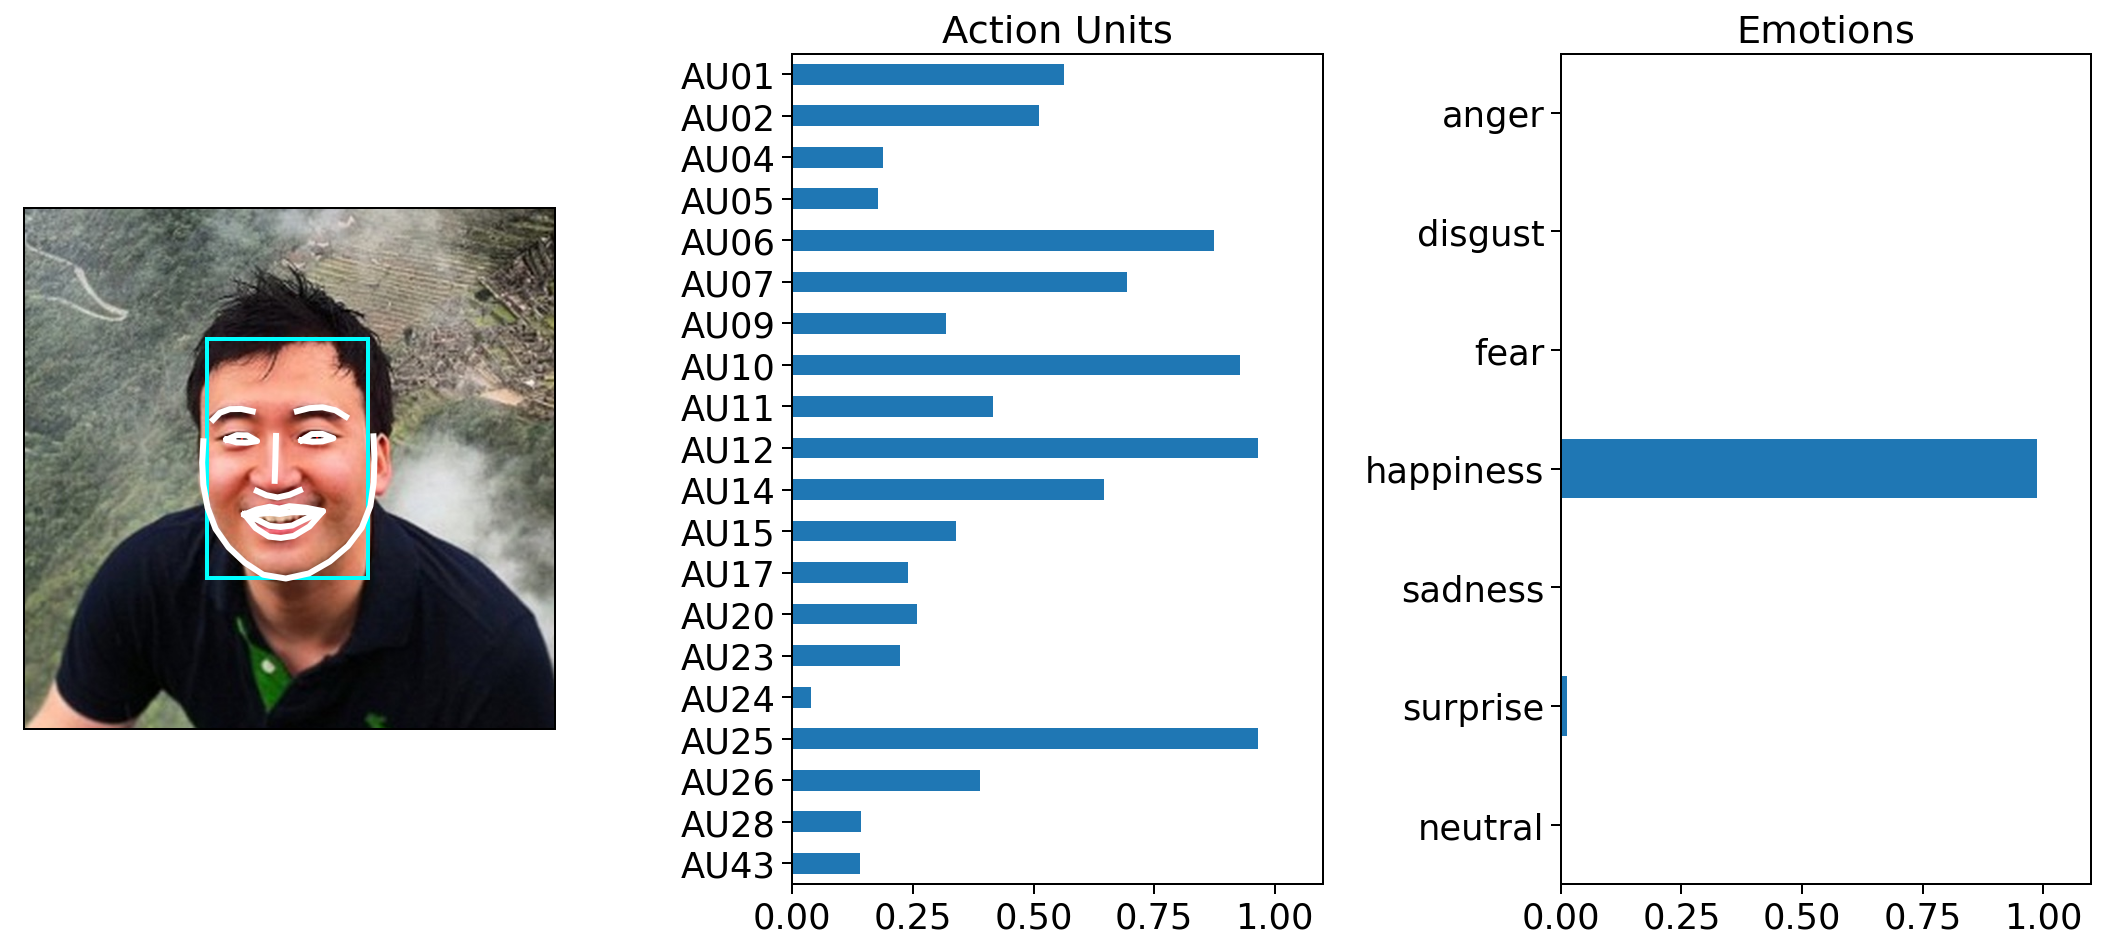

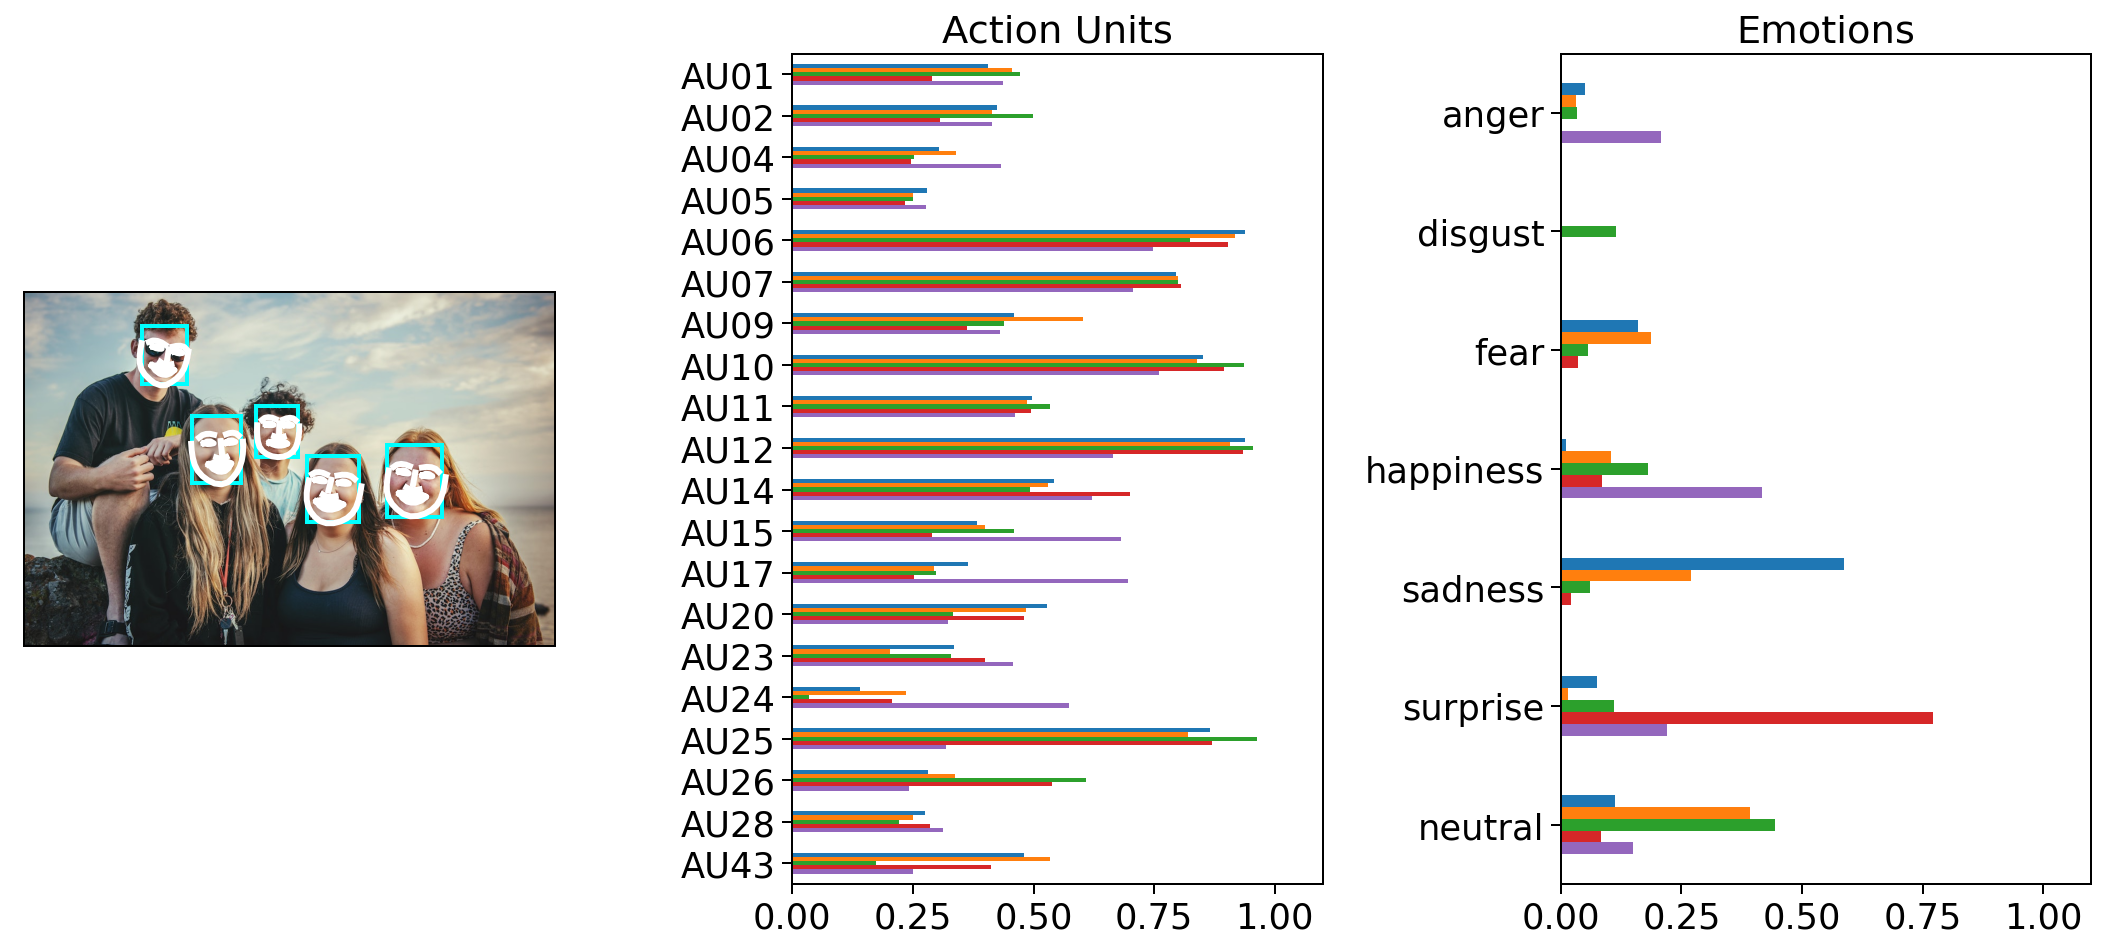

In [17]:
figs = mixed_prediction.plot_detections(add_titles=False)

However, it's easy to use pandas slicing sytax to just grab predictions for the image you want. For example you can use `.loc` and chain it to `.plot_detections()`:

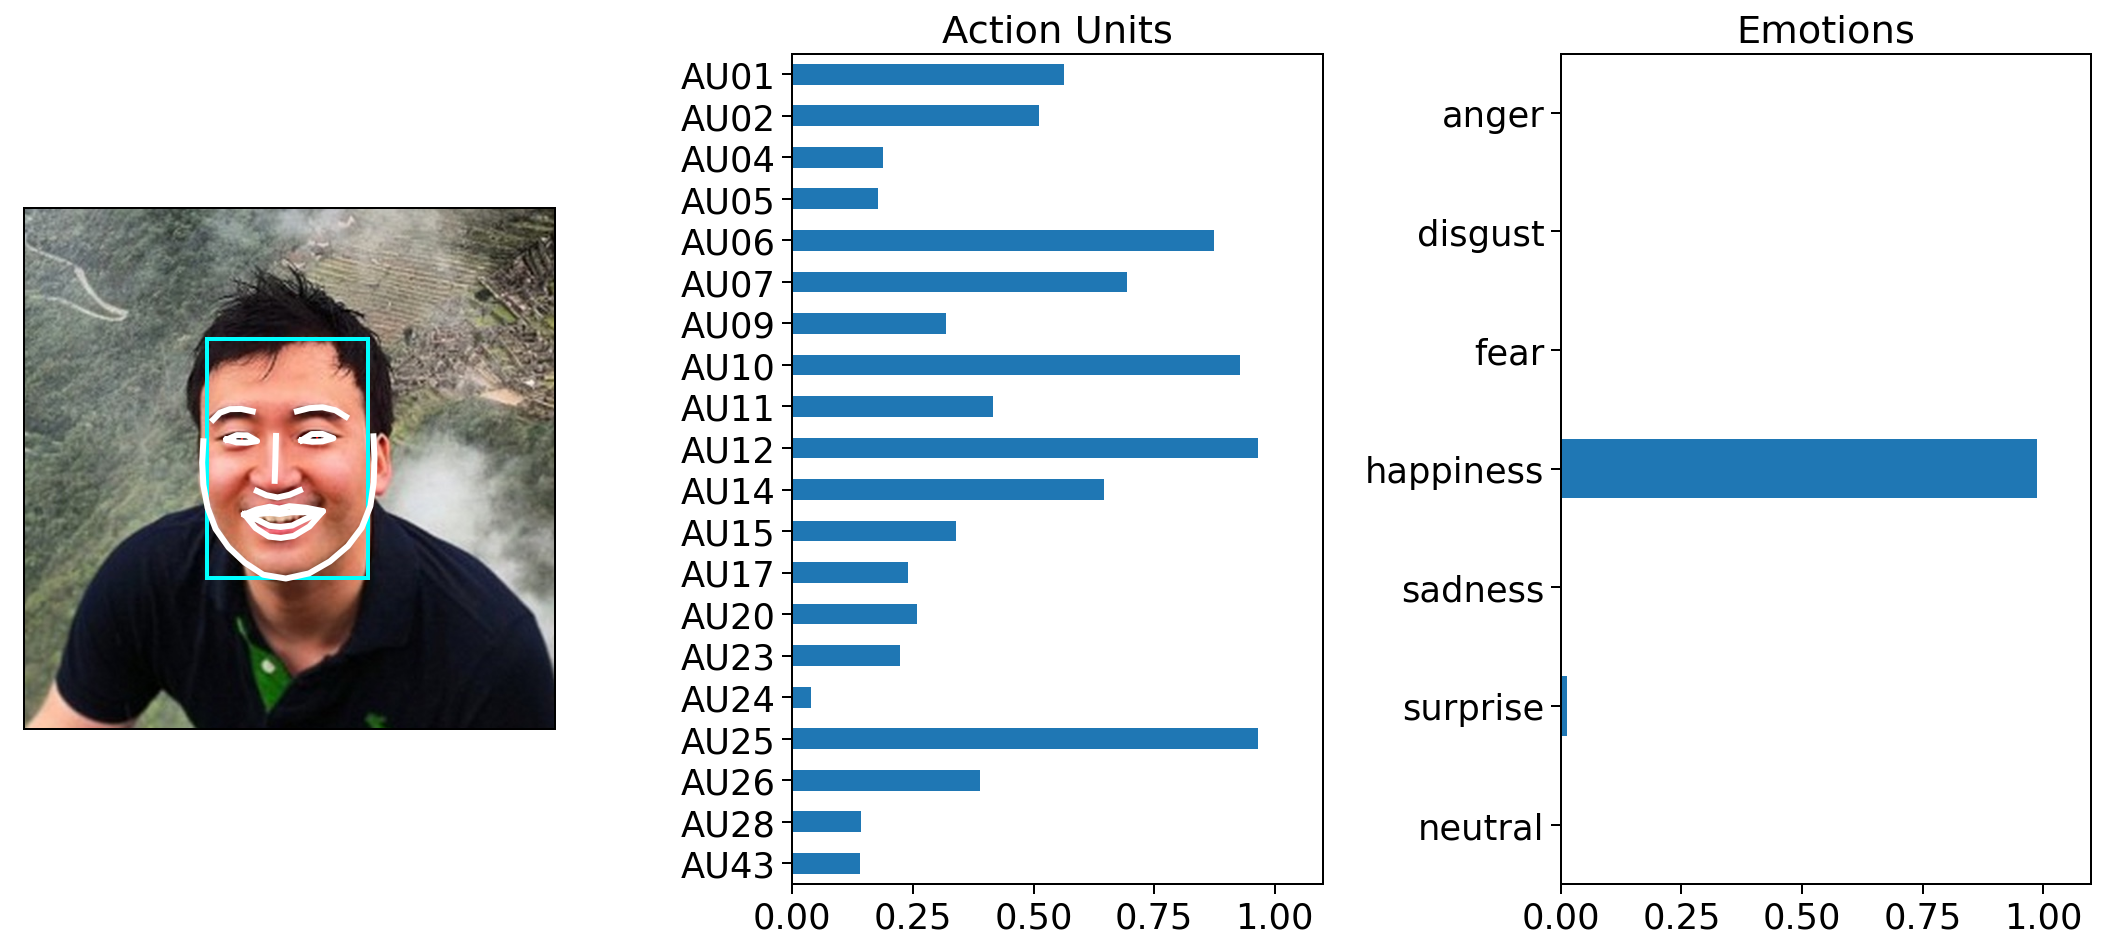

In [25]:
# Just plot the detection corresponding to the first row in the Fex data
figs = mixed_prediction.loc[0].plot_detections(add_titles=False)

Likewise you can use `.query()` and chain it to `.plot_detections()`. `Fex` data classes store each file path in the `'input'` column. So we can use regular pandas methods like `.unique()` to get all the unique images (2 in our case) and pick the second one.

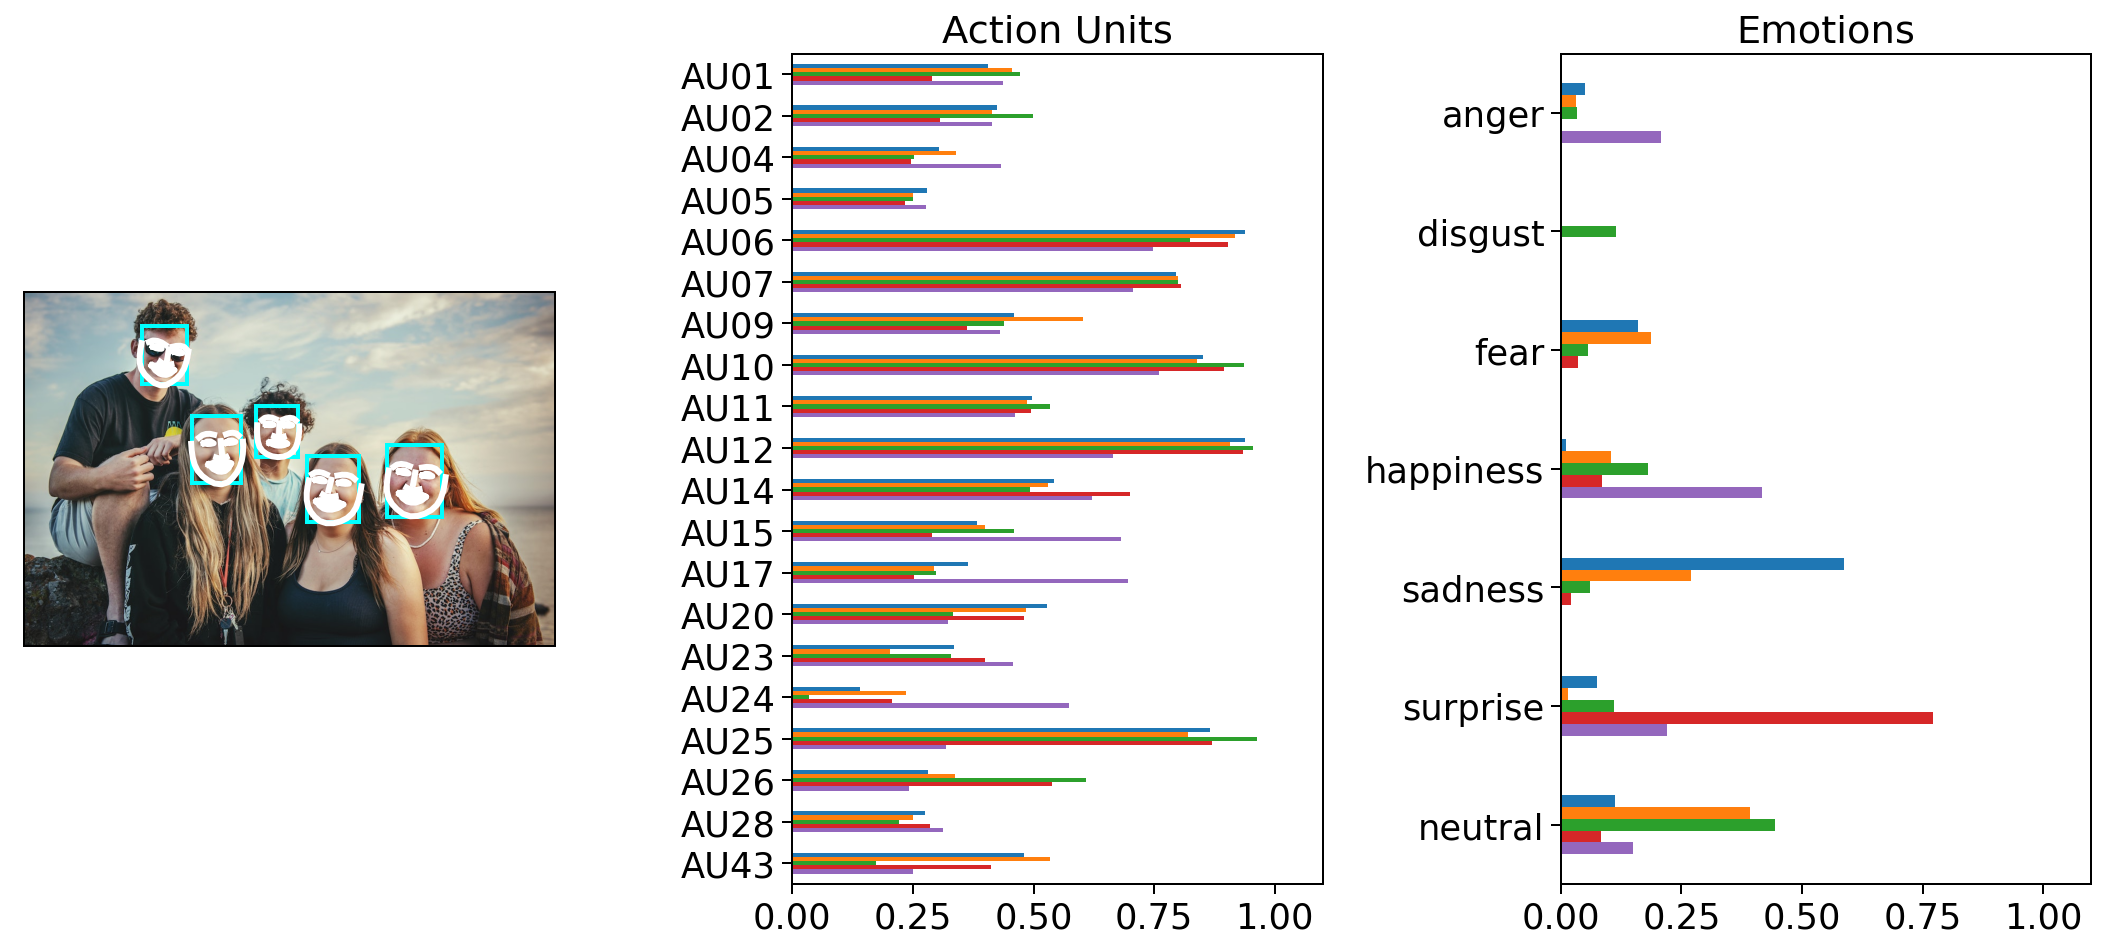

In [26]:
# Choose plot based on image file name
img_name = mixed_prediction['input'].unique()[1]
axes = mixed_prediction.query("input == @img_name").plot_detections(add_titles=False)